In [189]:
import pyvisa
import re
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('./nikhils_plot_style.mplstyle')

In [190]:
rm = pyvisa.ResourceManager()

print(rm.list_resources())

scope = rm.open_resource('USB0::0x2A8D::0x038B::CN60150271::INSTR')

print(scope.query('*IDN?'))

('USB0::0x2A8D::0x038B::CN60150271::INSTR',)
KEYSIGHT TECHNOLOGIES,EDUX1052A,CN60150271,02.12.2021071625



number of points in the waveform: 50000


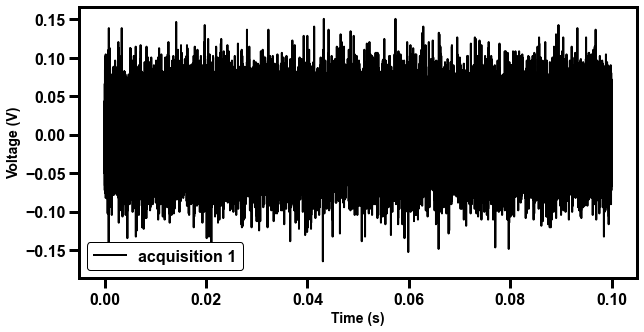

In [235]:

################ Measurement setup ################
num_acquisitions = 1
time_per_div = 1e-2 # s
volt_per_div = 5e-2 # V
TOTAL_TIME_DIVS = 10
TOTAL_VOLT_DIVS = 8
scope.write(':CHANnel1:PROBe 1.0') # probe attenuation factor is 1:1
scope.write(f':TIMebase:RANGe {time_per_div*TOTAL_TIME_DIVS}') # 1000ms total acquisition time
scope.write(f':CHANnel1:RANGe {volt_per_div*TOTAL_VOLT_DIVS}') # 400mV full scale
scope.write(':CHANnel1:COUPling AC')

################ Trigger setup ################
scope.write(':STOP')

# scope.write(':TRIGger:FORCe') # force trigger if no trigger is detected

################ Data acquisition ###############
data_list = []
scope.write(':WAVeform:SOURce CHANnel1')
scope.write(':WAVeform:FORMat ASCII')
for i in range(num_acquisitions):
    scope.write(':SINGLE')
    data = scope.query(':WAVeform:DATA?')
    data_list.append(data)

################ Data processing ################
for i, data in enumerate(data_list):
    data_list[i] = re.sub(r'\#\d+', '', data)
    data_list[i] = np.asarray([float(x) for x in data_list[i].split(',')])
    print(f"number of points in the waveform: {len(data_list[i])}")
time = np.linspace(0, time_per_div*TOTAL_TIME_DIVS, len(data_list[0]))

################ Plotting ################
fig, ax = plt.subplots(figsize=(10,5))
for i in range(num_acquisitions):
    ax.plot(time,data_list[i], label=f'acquisition {i+1}')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
ax.legend()
plt.show()

################ save data ################
np.savetxt('./data/data_1KOhm_single.csv', 
           np.concatenate((time.reshape(-1,1), np.transpose(data_list)), axis=-1), 
           delimiter=',')